In [1]:
from matplotlib import patches as mpatches
from mpl_chord_diagram import chord_diagram
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib as mpl
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import squidpy as sq
from matplotlib.lines import Line2D
from scipy import stats
import networkx as nx
import os

/home/yqcj/miniconda3/envs/squidpy/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [2]:
def select_slide(adata, s, batch_key="sample"):
    r"""This function selects the data for one slide from the spatial anndata object.

    :param adata: Anndata object with multiple spatial experiments
    :param s: name of selected experiment
    :param batch_key: column in adata.obs listing experiment name for each location
    """
    slide = adata[adata.obs[batch_key].isin([s]), :].copy()
    s_keys = list(slide.uns["spatial"].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns["spatial"] = {s_spatial: slide.uns["spatial"][s_spatial]}

    return slide

def get_range(list_int):
    import numpy as np
    # Define your list of floats
    data = list_int
    # Determine the range of values in the data set
    data_range = max(data) - min(data)
    # Calculate the bin size based on the desired number of bins
    num_bins = 5
    bin_size = data_range / num_bins
    # Use the histogram function to get the frequency counts and bin edges
    counts, edges = np.histogram(data, bins=num_bins)
    # Create a list of representative integers based on the bin edges
    integers = [int(round(edge)) for edge in edges]
    # Print the results
    print(f"Counts: {counts}")
    print(f"Bin Edges: {integers}") 
    return integers

In [3]:
adata_all = sc.read_h5ad("/mnt/g/E-disk/ZJH_KRAS/Workdir/4.Cell2location/cell2location_map/sp.h5ad")
adata_all

AnnData object with n_obs × n_vars = 8113 × 12453
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'group', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', '_indices', '_scvi_batch', '_scvi_labels', 'CD4_Tcm', 'CD4_Tem', 'Treg', 'CD8_Tem', 'CD8_Tex', 'T_Prolif', 'NK_cells', 'DCs', 'Macro_C1QC', 'Macro_TNFRSF17', 'Mono_MALAT1', 'Mono_S100A8', 'Fib_CTHRC1', 'Fib_CXCL14', 'Fib_GAL', 'Fib_IGF1', 'Fib_MMP1', 'Fib_PRKG1', 'Pericytes', 'SMCs', 'Epi_01', 'Epi_02', 'Epi_03', 'Epi_04', 'Epi_05', 'Epi_06', 'Epi_07', 'Epi_08', 'Epi_09', 'Epi_10', 'Endothelial_cells', 'B_cells', 'Mast_cells', 'Plasma_cells'
    var: 'gene_ids', 'feature_types', 'genome', 'SYMBOL', 'mt', 'rps', 'mrp', 'rpl', 'duplicated', 'n_cells_by_counts-CRC_MUT_A1', 'mean_counts-CRC_MUT_A1', 'pct_dropout_by_counts-CRC_MUT_A1',

In [4]:
adata_all.obsm['q05_cell_abundance_w_sf'].columns = [col.replace('q05cell_abundance_w_sf_', '') for col in adata_all.obsm['q05_cell_abundance_w_sf'].columns]
cell_type_scores=adata_all.obsm['q05_cell_abundance_w_sf']
cell_type_scores
# 如果 cell_type_scores 是 NumPy 数组，转换为 DataFrame 以便更好地处理
if isinstance(cell_type_scores, np.ndarray):
    cell_type_scores_df = pd.DataFrame(cell_type_scores)
else:
    cell_type_scores_df = cell_type_scores

# 定义一个函数来进行最小-最大缩放
def min_max_scale(df):
    return (df - df.min()) / (df.max() - df.min())

# 对每一列进行标准化
cell_type_scores_scaled = min_max_scale(cell_type_scores_df)

# 将标准化后的数据放回 AnnData 对象
adata_all.obsm['q05_cell_abundance_w_sf'] = cell_type_scores_scaled
# 或者如果你想直接更新obs中的注释信息，可以根据最高评分分配主要细胞类型
adata_all.obs['predicted_cell_type'] = adata_all.obsm['q05_cell_abundance_w_sf'].idxmax(axis=1)
ordered_categories = ['CD4_Tcm', 'CD4_Tem','Treg', 'CD8_Tem', 'CD8_Tex','T_Prolif','NK_cells',
       'DCs','Macro_C1QC', 'Macro_TNFRSF17','Mono_MALAT1', 'Mono_S100A8',
       'Fib_CTHRC1', 'Fib_CXCL14', 'Fib_GAL','Fib_IGF1', 'Fib_MMP1', 'Fib_PRKG1','Pericytes','SMCs',
       'Epi_01', 'Epi_02', 'Epi_03', 'Epi_04', 'Epi_05', 'Epi_06', 'Epi_07',
       'Epi_08', 'Epi_09', 'Epi_10', 'Endothelial_cells','B_cells','Mast_cells', 'Plasma_cells'
        ]

# 按照定义的顺序排序
adata_all.obs['predicted_cell_type'] = pd.Categorical(adata_all.obs['predicted_cell_type'], categories=ordered_categories, ordered=True)

# 第一个样本

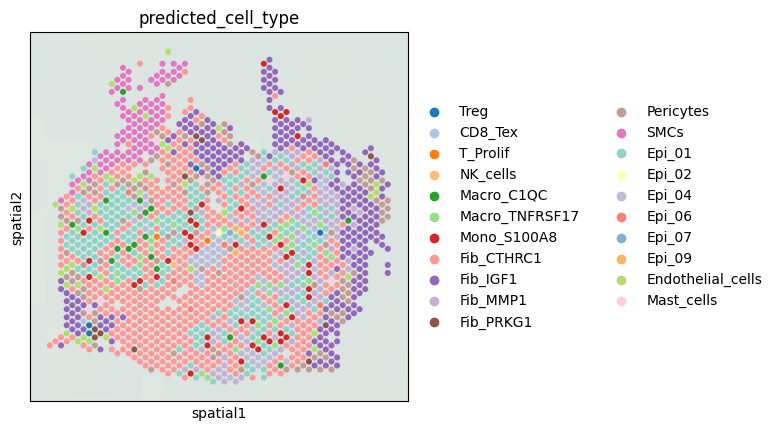

/home/yqcj/miniconda3/envs/squidpy/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:981: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


  0%|          | 0/1000 [00:00<?, ?/s]

/home/yqcj/miniconda3/envs/squidpy/lib/python3.9/site-packages/squidpy/gr/_nhood.py:202: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


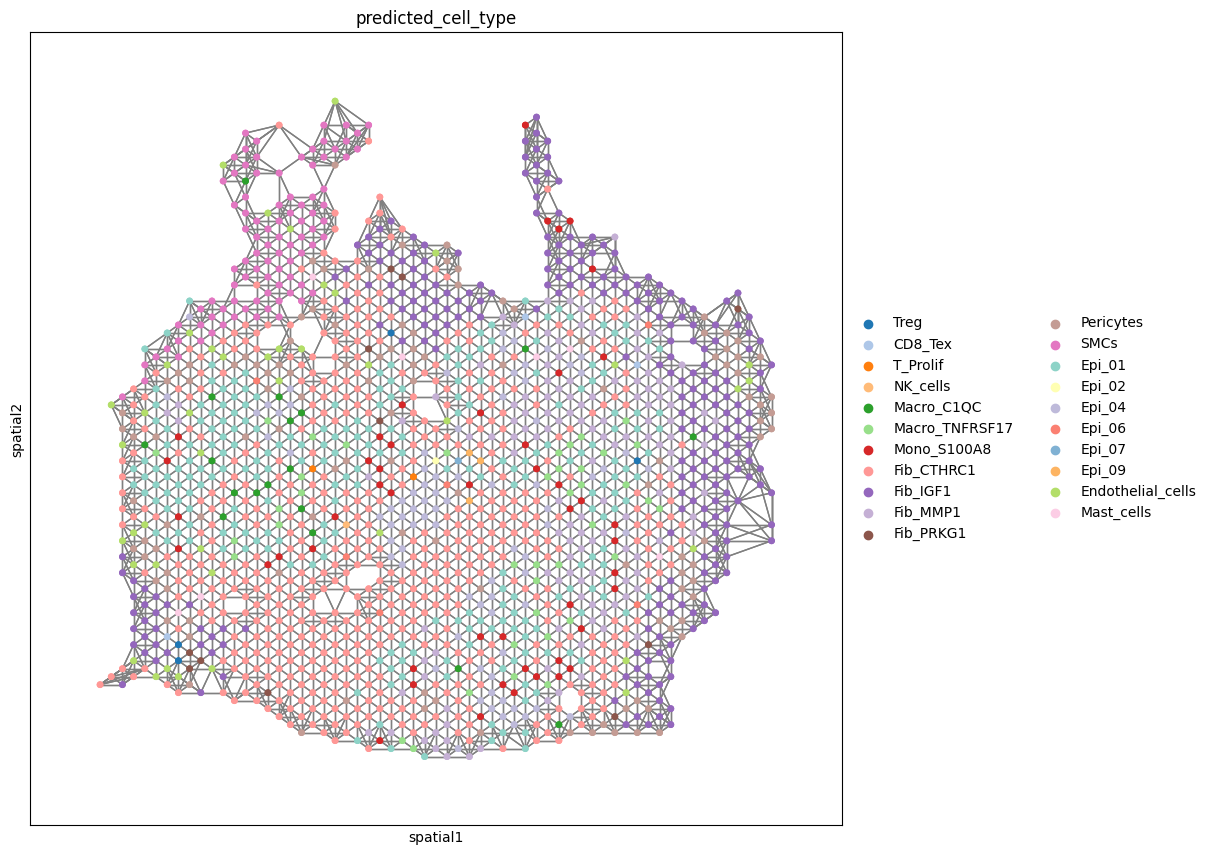

In [5]:
sample_names=adata_all.obs['sample'].unique().tolist()
sample=sample_names[0]
adata=select_slide(adata_all, sample)
adata
adata.obs["array_row"]=adata.obs["array_row"]*1.4  #这个参数需要根据图长宽调整
adata.obsm["spatial"] = adata.obs[["array_row", "array_col"]].copy().to_numpy()
# 创建一个有30个颜色的调色板
palette = sns.color_palette("tab20", n_colors=13) + sns.color_palette("Set3", n_colors=20)
# 去除重复颜色
palette = list(dict.fromkeys(palette))  # 利用字典去重
sc.pl.spatial(adata, color="predicted_cell_type", spot_size=1.5,palette=palette,save="_"+sample+"_predict_Celltype_newcolor")
####计算邻域
sq.gr.spatial_neighbors(adata, library_key = 'sample',  coord_type="generic", delaunay=False,  n_neighs=6)
sq.pl.spatial_scatter(adata, 
                      color = 'predicted_cell_type',
                      #coords=adata.obsm['spatial'],
                     # crop_coord=region_subset_dict[sample],
                      size= 60,shape=None,
                      figsize=(12, 12), 
                      connectivity_key = 'spatial_connectivities', 
                     )#save = sample+'.svg')
output_dir = sample+"_Network/"
os.makedirs(output_dir, exist_ok=True)  # 创建目录（如果不存在）
plt.savefig(output_dir+'spatial_interaction.pdf')
sq.gr.nhood_enrichment(adata, cluster_key='predicted_cell_type')
adata.uns['predicted_cell_type'+'_nhood_enrichment']['zscore'] = np.nan_to_num(adata.uns['predicted_cell_type'+'_nhood_enrichment']['zscore'])
colors =pd.DataFrame(dict(zip(adata.obs['predicted_cell_type'].cat.categories,adata.uns['predicted_cell_type_colors'])).values())#pd.DataFrame(adata.uns['predicted_cell_type'+'_colors'])
for_eneritz = pd.DataFrame(adata.uns['predicted_cell_type'+"_nhood_enrichment"]["zscore"])
for_eneritz.index = adata.obs['predicted_cell_type'].cat.categories
for_eneritz.columns = adata.obs['predicted_cell_type'].cat.categories
#for_eneritz.to_csv(path+'SC_'+int_group+'_'+time+'_interaction_matrix.csv')
size = pd.DataFrame(adata.obs['predicted_cell_type'].value_counts())
# create network plot
G = nx.Graph()
nodes = adata.obs['predicted_cell_type'].cat.categories
categories = pd.DataFrame(adata.obs['predicted_cell_type'].cat.categories)
colors['cells'] = categories
nodes2 = []
for i,node in enumerate(((nodes))):
            for j in range(i+1, len(nodes)):
                zscore = adata.uns['predicted_cell_type'+"_nhood_enrichment"]["zscore"][i, j]
                pval = stats.norm.sf(abs(zscore))*2
                if zscore>1:
                    G.add_edge(nodes[i], nodes[j], weight=(zscore))
                    pos = nx.spring_layout(G, k=0.5, seed=42)
size = size[size.index.isin(pos.keys())]
size = size.sort_index()
colors = colors[colors.cells.isin(pos.keys())]
colors = dict(zip(colors['cells'], colors[0]))
edge_widths = [d['weight'] for u, v, d in G.edges(data=True)]
size = dict(zip(size.index, size['count']))
node_size = [size[node] for node in G.nodes()]
node_colors = [colors[node] for node in G.nodes()]

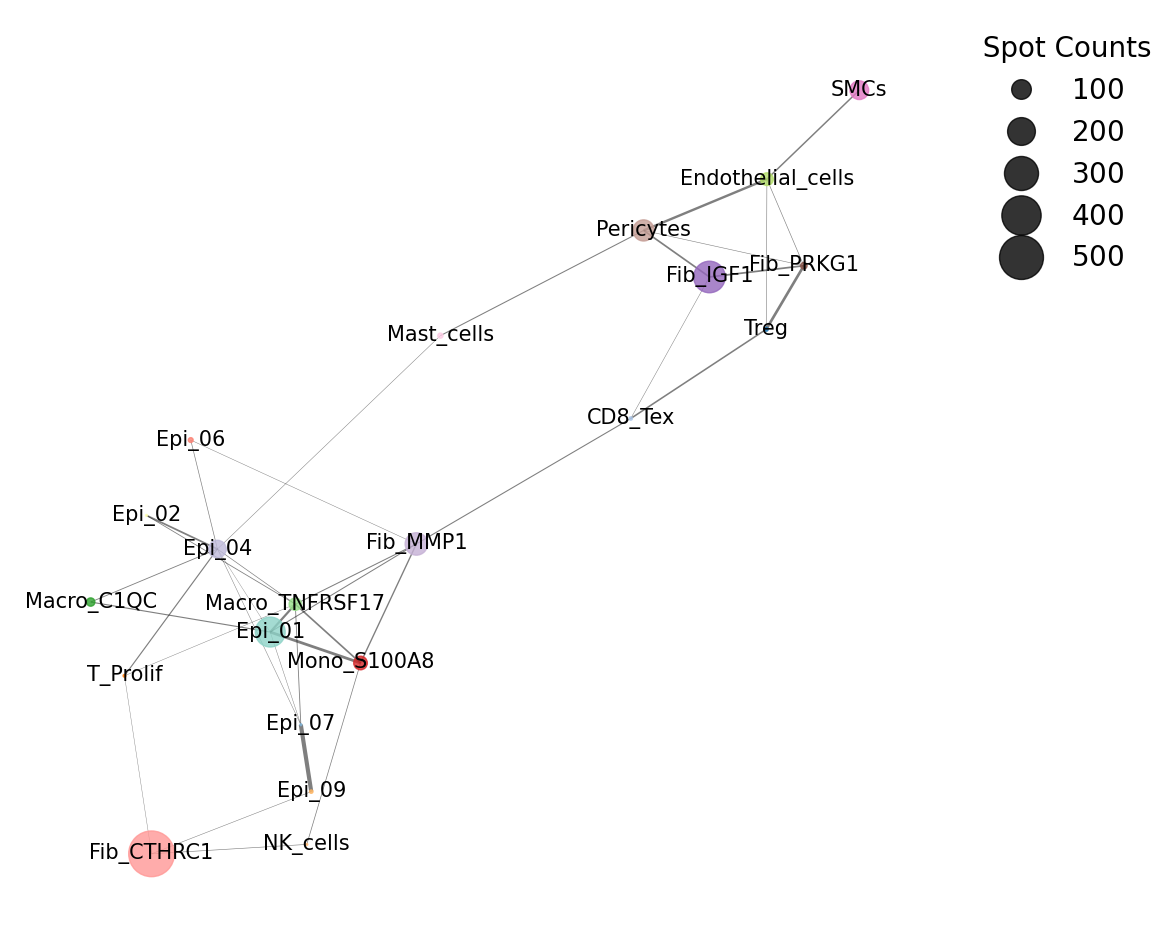

In [6]:
plt.figure(figsize=(12, 12))
#尽量不要使用sc赋值，会和scanpy缩写冲突，这里改为sc_nodes
pos = nx.spring_layout(G, k=0.5)  # 适当增大 k 值防止label重合
sc_nodes = nx.draw_networkx_nodes(G, pos, node_color=node_colors, alpha=0.8, node_size=np.array(node_size)*2)
nx.draw_networkx_edges(G, pos, edge_color="black", alpha=0.5, width=0.25*(np.array(edge_widths)))
nx.draw_networkx_labels(G, pos, font_size=15, font_color="black")
plt.axis("off")
plt.legend(*sc_nodes.legend_elements("sizes", num=6,func=lambda s: s / 2),
                   bbox_to_anchor=(1, 1), 
                   prop={'size': 20},
                   title = '  Spot Counts',
                   title_fontsize=20,  # 设置标题字体大小
                   frameon = False)
#func=lambda s: s / 2 作用是将图例中的节点大小除以 2，这样图例就会显示你希望的值。
plt.savefig(output_dir+'SC_Network.svg', bbox_inches="tight", dpi = 600) #bbox_inches="tight" 表示自动调整图形的边界，使图形内容完全显示。
plt.show()

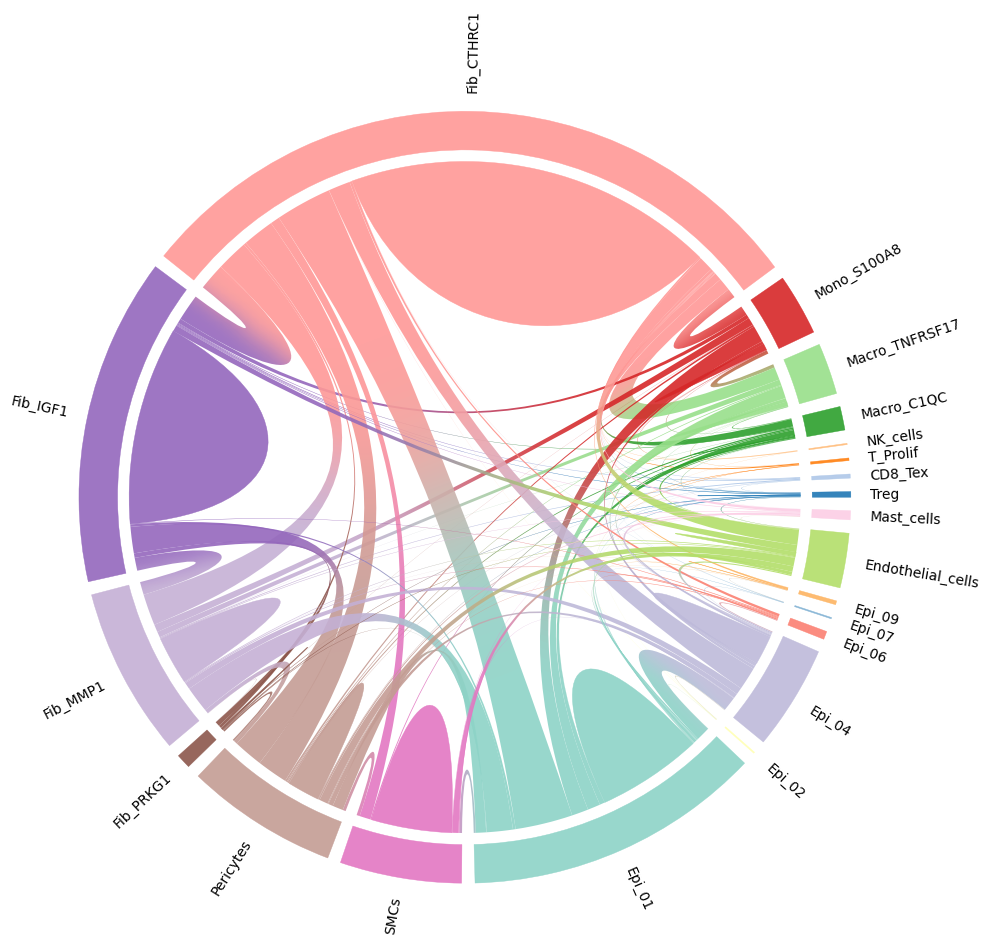

In [7]:
sq.gr.interaction_matrix(adata, cluster_key='predicted_cell_type', normalized = False)
#sq.pl.interaction_matrix(adata, cluster_key='predicted_cell_type',)# vmax = 5000, method="ward",)
df = pd.DataFrame(adata.uns['predicted_cell_type'+'_interactions'])
df_filt = df#[df.sum() > df.sum().quantile(0.6)]
df_filt = df_filt.T
df_filt = df_filt[df_filt.index.isin(df_filt.columns)]
colors =pd.DataFrame(adata.uns['predicted_cell_type'+'_colors'])
colors = colors[colors.index.isin(df_filt.columns)][0]
categories = pd.DataFrame(adata.obs['predicted_cell_type'].cat.categories)
categories = categories[categories.index.isin(df_filt.columns)][0]
df_filt.index = categories
df_filt.columns = categories
import random
randomlist = []
for i in range(0,19):
    n = random.uniform(0,1,)
    randomlist.append(n)
#df.index= adata.obs.level3.cat.categories
#df.columns= adata.obs.level3.cat.categories
with plt.rc_context({'figure.figsize': (10, 10), 'figure.dpi':100}):
    chord_diagram(df_filt, names = list(categories), 
                  rotate_names = True, fontcolor = 'black',
                  fontsize=10,colors = list(colors), alpha = 0.90,
                 sort = 'distance', use_gradient= True, show= False)
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42
    plt.rcParams['svg.fonttype'] = 'none'
    plt.savefig(output_dir+'SC_interaction_matrix.svg', bbox_inches="tight")
plt.show()

# 第二个样本

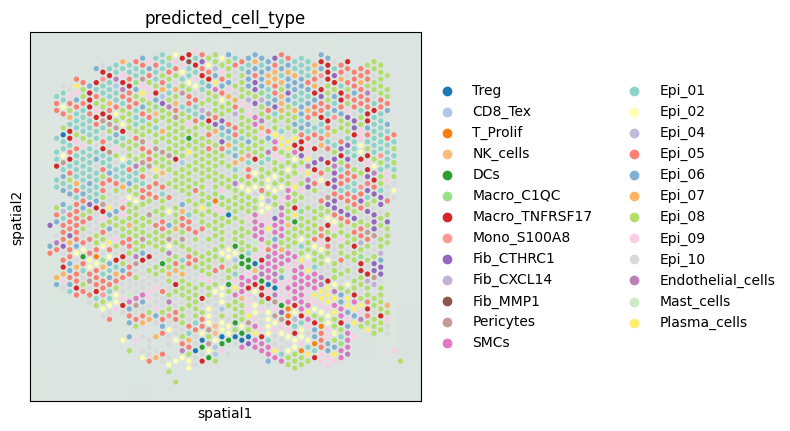

/home/yqcj/miniconda3/envs/squidpy/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:981: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


  0%|          | 0/1000 [00:00<?, ?/s]

/home/yqcj/miniconda3/envs/squidpy/lib/python3.9/site-packages/squidpy/gr/_nhood.py:202: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


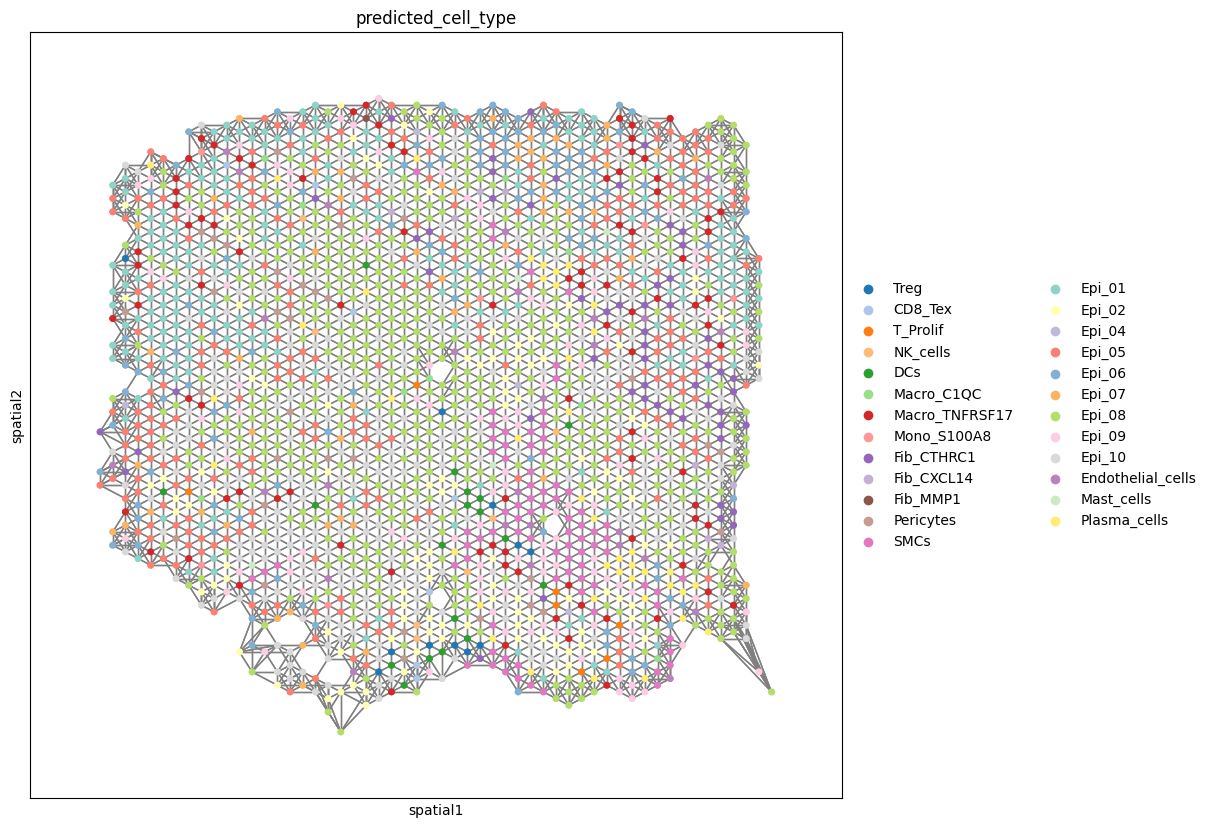

In [8]:
sample=sample_names[1]
adata=select_slide(adata_all, sample)
adata
adata.obs["array_row"]=adata.obs["array_row"]*1.9  #这个参数需要根据图长宽调整
adata.obsm["spatial"] = adata.obs[["array_row", "array_col"]].copy().to_numpy()
# 创建一个有30个颜色的调色板
palette = sns.color_palette("tab20", n_colors=13) + sns.color_palette("Set3", n_colors=20)
# 去除重复颜色
palette = list(dict.fromkeys(palette))  # 利用字典去重
import matplotlib.pyplot as plt
sc.pl.spatial(adata, color="predicted_cell_type", spot_size=1.5,palette=palette,save="_"+sample+"_predict_Celltype_newcolor")
####计算邻域
sq.gr.spatial_neighbors(adata, library_key = 'sample',  coord_type="generic", delaunay=False,  n_neighs=6)
sq.pl.spatial_scatter(adata, 
                      color = 'predicted_cell_type',
                      #coords=adata.obsm['spatial'],
                     # crop_coord=region_subset_dict[sample],
                      size= 60,shape=None,
                      figsize=(12, 12), 
                      connectivity_key = 'spatial_connectivities', 
                     )#save = sample+'.svg')
output_dir = sample+"_Network/"
os.makedirs(output_dir, exist_ok=True)  # 创建目录（如果不存在）
plt.savefig(output_dir+'spatial_interaction.pdf')
sq.gr.nhood_enrichment(adata, cluster_key='predicted_cell_type')
adata.uns['predicted_cell_type'+'_nhood_enrichment']['zscore'] = np.nan_to_num(adata.uns['predicted_cell_type'+'_nhood_enrichment']['zscore'])
colors =pd.DataFrame(dict(zip(adata.obs['predicted_cell_type'].cat.categories,adata.uns['predicted_cell_type_colors'])).values())#pd.DataFrame(adata.uns['predicted_cell_type'+'_colors'])
for_eneritz = pd.DataFrame(adata.uns['predicted_cell_type'+"_nhood_enrichment"]["zscore"])
for_eneritz.index = adata.obs['predicted_cell_type'].cat.categories
for_eneritz.columns = adata.obs['predicted_cell_type'].cat.categories
#for_eneritz.to_csv(path+'SC_'+int_group+'_'+time+'_interaction_matrix.csv')
size = pd.DataFrame(adata.obs['predicted_cell_type'].value_counts())
# create network plot
G = nx.Graph()
nodes = adata.obs['predicted_cell_type'].cat.categories
categories = pd.DataFrame(adata.obs['predicted_cell_type'].cat.categories)
colors['cells'] = categories
nodes2 = []
for i,node in enumerate(((nodes))):
            for j in range(i+1, len(nodes)):
                zscore = adata.uns['predicted_cell_type'+"_nhood_enrichment"]["zscore"][i, j]
                pval = stats.norm.sf(abs(zscore))*2
                if zscore>1:
                    G.add_edge(nodes[i], nodes[j], weight=(zscore))
                    pos = nx.spring_layout(G, k=0.5, seed=42)
size = size[size.index.isin(pos.keys())]
size = size.sort_index()
colors = colors[colors.cells.isin(pos.keys())]
colors = dict(zip(colors['cells'], colors[0]))
edge_widths = [d['weight'] for u, v, d in G.edges(data=True)]
size = dict(zip(size.index, size['count']))
node_size = [size[node] for node in G.nodes()]
node_colors = [colors[node] for node in G.nodes()]

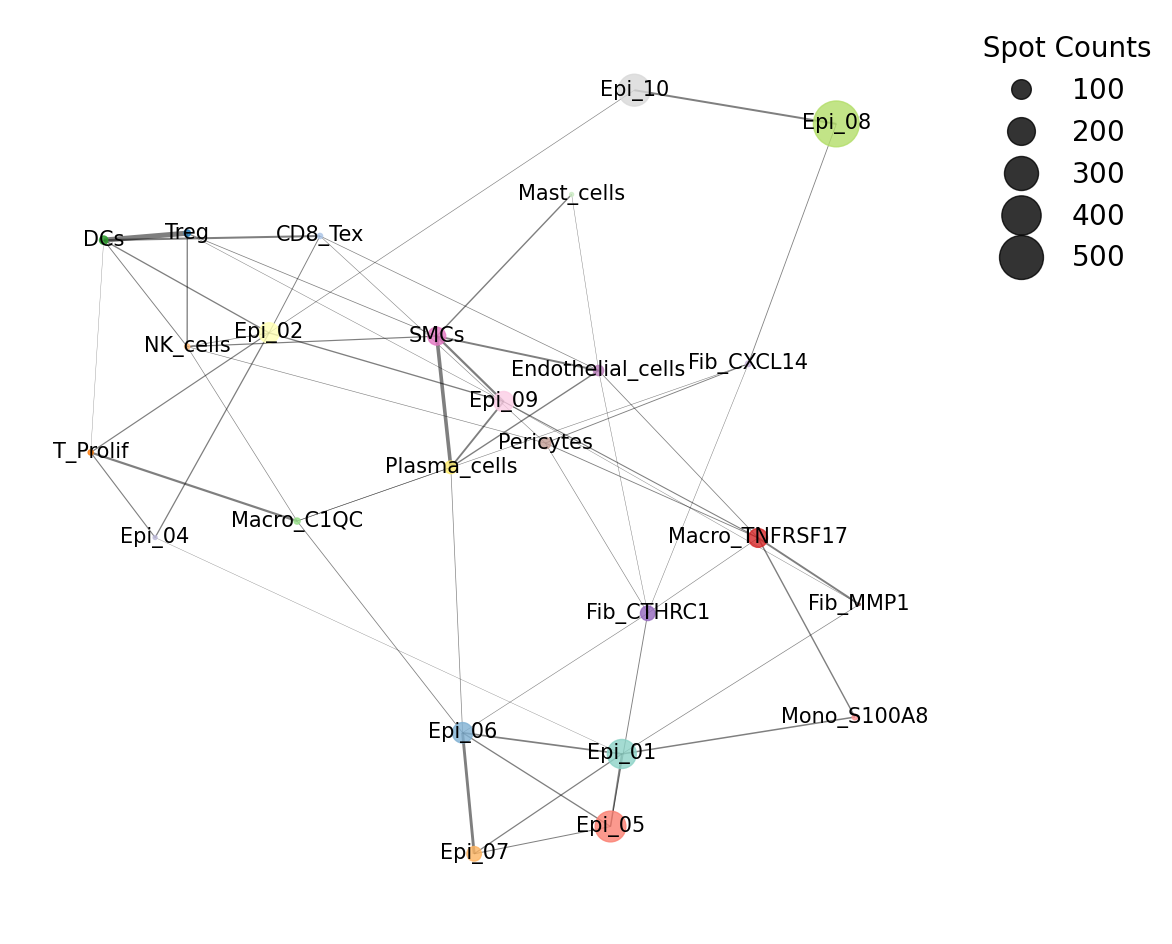

In [9]:
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.5)  # 适当增大 k 值防止label重合
sc_nodes = nx.draw_networkx_nodes(G, pos, node_color=node_colors, alpha=0.8, node_size=np.array(node_size)*2)
nx.draw_networkx_edges(G, pos, edge_color="black", alpha=0.5, width=0.25*(np.array(edge_widths)))
nx.draw_networkx_labels(G, pos, font_size=15, font_color="black")
plt.axis("off")
plt.legend(*sc_nodes.legend_elements("sizes", num=6,func=lambda s: s / 2),
                   bbox_to_anchor=(1, 1), 
                   prop={'size': 20},
                   title = '  Spot Counts',
                   title_fontsize=20,  # 设置标题字体大小
                   frameon = False)
#func=lambda s: s / 2 作用是将图例中的节点大小除以 2，这样图例就会显示你希望的值。
plt.savefig(output_dir+'SC_Network.svg', bbox_inches="tight", dpi = 600) #bbox_inches="tight" 表示自动调整图形的边界，使图形内容完全显示。
plt.show()

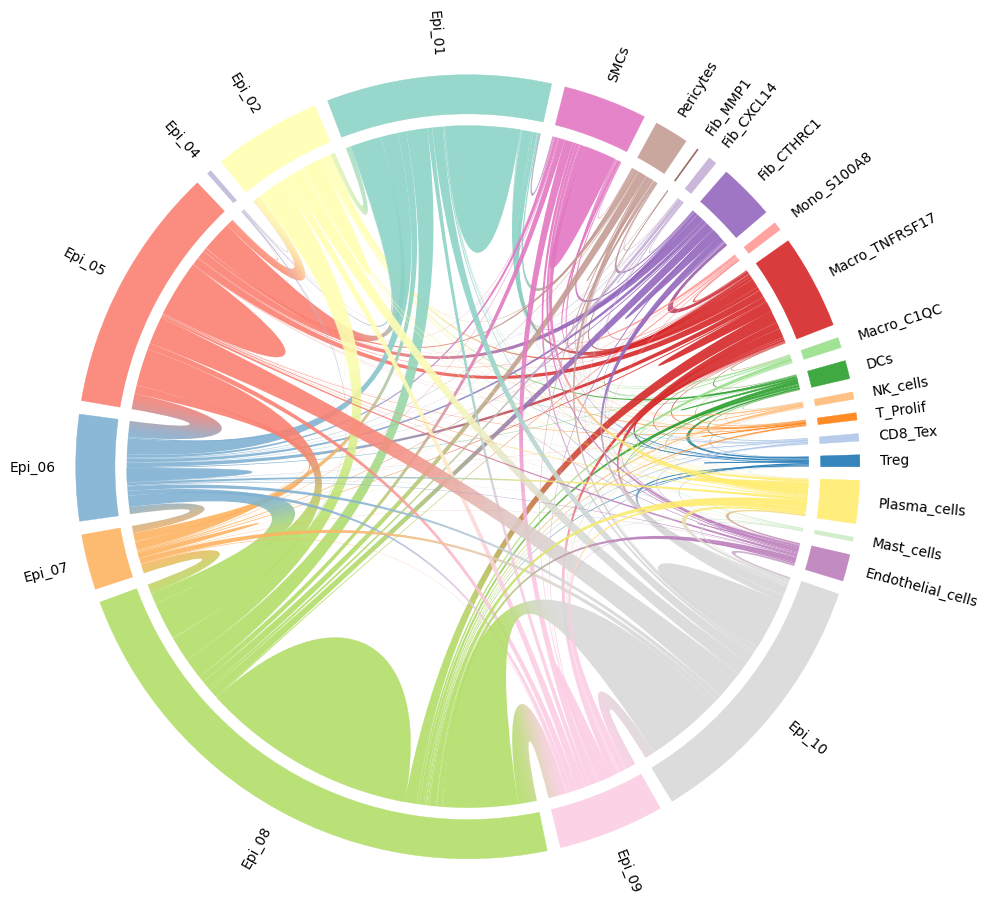

In [10]:
sq.gr.interaction_matrix(adata, cluster_key='predicted_cell_type', normalized = False)
#sq.pl.interaction_matrix(adata, cluster_key='predicted_cell_type',)# vmax = 5000, method="ward",)
df = pd.DataFrame(adata.uns['predicted_cell_type'+'_interactions'])
df_filt = df#[df.sum() > df.sum().quantile(0.6)]
df_filt = df_filt.T
df_filt = df_filt[df_filt.index.isin(df_filt.columns)]
colors =pd.DataFrame(adata.uns['predicted_cell_type'+'_colors'])
colors = colors[colors.index.isin(df_filt.columns)][0]
categories = pd.DataFrame(adata.obs['predicted_cell_type'].cat.categories)
categories = categories[categories.index.isin(df_filt.columns)][0]
df_filt.index = categories
df_filt.columns = categories
import random
randomlist = []
for i in range(0,19):
    n = random.uniform(0,1,)
    randomlist.append(n)
#df.index= adata.obs.level3.cat.categories
#df.columns= adata.obs.level3.cat.categories
with plt.rc_context({'figure.figsize': (10, 10), 'figure.dpi':100}):
    chord_diagram(df_filt, names = list(categories), 
                  rotate_names = True, fontcolor = 'black',
                  fontsize=10,colors = list(colors), alpha = 0.90,
                 sort = 'distance', use_gradient= True, show= False)
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42
    plt.rcParams['svg.fonttype'] = 'none'
    plt.savefig(output_dir+'SC_interaction_matrix.svg', bbox_inches="tight")
plt.show()

# 第三个样本

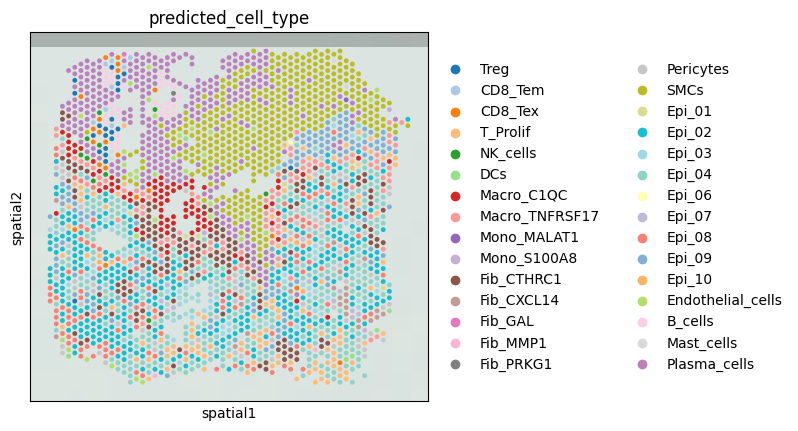

/home/yqcj/miniconda3/envs/squidpy/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:981: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


  0%|          | 0/1000 [00:00<?, ?/s]

/home/yqcj/miniconda3/envs/squidpy/lib/python3.9/site-packages/squidpy/gr/_nhood.py:202: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


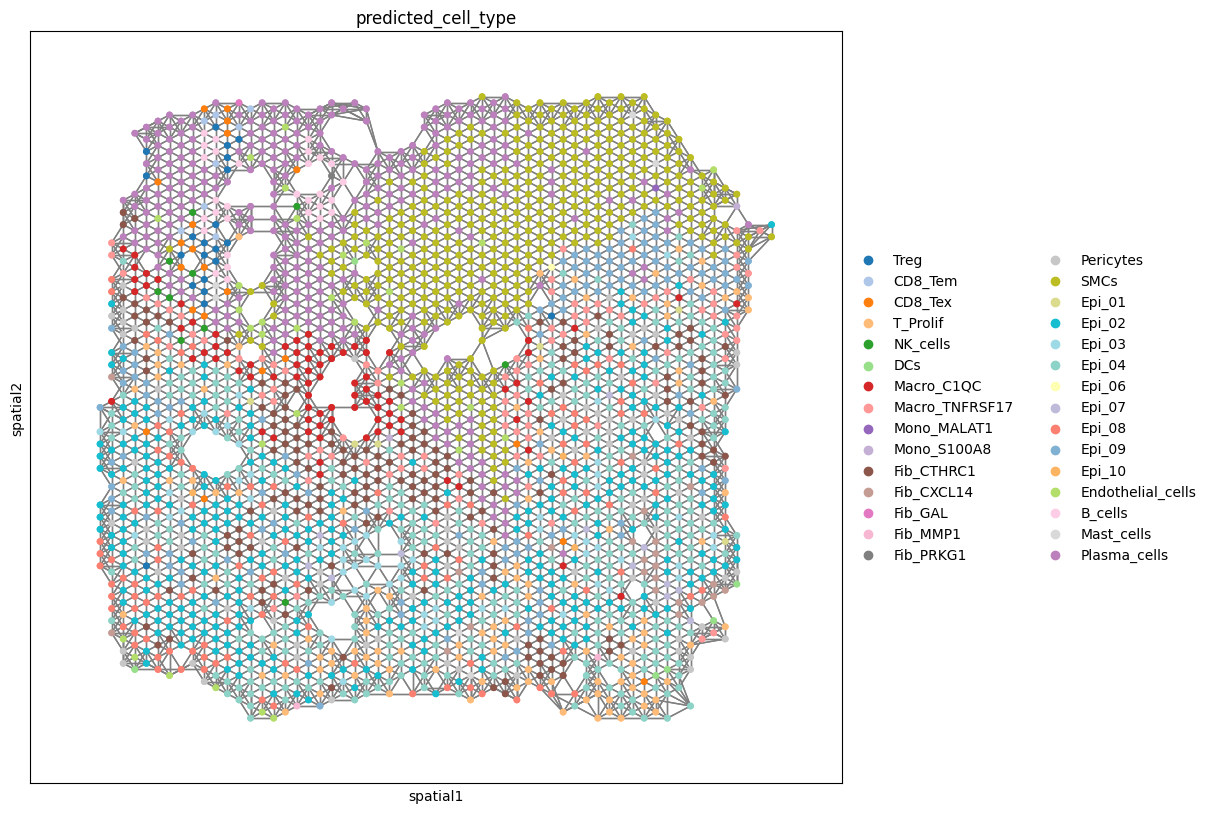

In [79]:
sample=sample_names[2]
adata=select_slide(adata_all, sample)
adata
adata.obs["array_row"]=adata.obs["array_row"]*1.9  #这个参数需要根据图长宽调整
adata.obsm["spatial"] = adata.obs[["array_row", "array_col"]].copy().to_numpy()
# 创建一个有30个颜色的调色板
palette = sns.color_palette("tab20", n_colors=20) + sns.color_palette("Set3", n_colors=20)
# 去除重复颜色
palette = list(dict.fromkeys(palette))  # 利用字典去重
sc.pl.spatial(adata, color="predicted_cell_type", spot_size=1.5,palette=palette,save="_"+sample+"_predict_Celltype_newcolor")
####计算邻域
sq.gr.spatial_neighbors(adata, library_key = 'sample',  coord_type="generic", delaunay=False,  n_neighs=6)
sq.pl.spatial_scatter(adata, 
                      color = 'predicted_cell_type',
                      #coords=adata.obsm['spatial'],
                     # crop_coord=region_subset_dict[sample],
                      size= 60,shape=None,
                      figsize=(12, 12), 
                      connectivity_key = 'spatial_connectivities', 
                     )#save = sample+'.svg')
output_dir = sample+"_Network/"
os.makedirs(output_dir, exist_ok=True)  # 创建目录（如果不存在）
plt.savefig(output_dir+'spatial_interaction.pdf')
sq.gr.nhood_enrichment(adata, cluster_key='predicted_cell_type')
adata.uns['predicted_cell_type'+'_nhood_enrichment']['zscore'] = np.nan_to_num(adata.uns['predicted_cell_type'+'_nhood_enrichment']['zscore'])
colors =pd.DataFrame(dict(zip(adata.obs['predicted_cell_type'].cat.categories,adata.uns['predicted_cell_type_colors'])).values())#pd.DataFrame(adata.uns['predicted_cell_type'+'_colors'])
for_eneritz = pd.DataFrame(adata.uns['predicted_cell_type'+"_nhood_enrichment"]["zscore"])
for_eneritz.index = adata.obs['predicted_cell_type'].cat.categories
for_eneritz.columns = adata.obs['predicted_cell_type'].cat.categories
#for_eneritz.to_csv(path+'SC_'+int_group+'_'+time+'_interaction_matrix.csv')
size = pd.DataFrame(adata.obs['predicted_cell_type'].value_counts())
# create network plot
G = nx.Graph()
nodes = adata.obs['predicted_cell_type'].cat.categories
categories = pd.DataFrame(adata.obs['predicted_cell_type'].cat.categories)
colors['cells'] = categories
nodes2 = []
for i,node in enumerate(((nodes))):
            for j in range(i+1, len(nodes)):
                zscore = adata.uns['predicted_cell_type'+"_nhood_enrichment"]["zscore"][i, j]
                pval = stats.norm.sf(abs(zscore))*2
                if zscore>1:
                    G.add_edge(nodes[i], nodes[j], weight=(zscore))
                    pos = nx.spring_layout(G, k=0.5, seed=42)
size = size[size.index.isin(pos.keys())]
size = size.sort_index()
colors = colors[colors.cells.isin(pos.keys())]
colors = dict(zip(colors['cells'], colors[0]))
edge_widths = [d['weight'] for u, v, d in G.edges(data=True)]
size = dict(zip(size.index, size['count']))
node_size = [size[node] for node in G.nodes()]
node_colors = [colors[node] for node in G.nodes()]

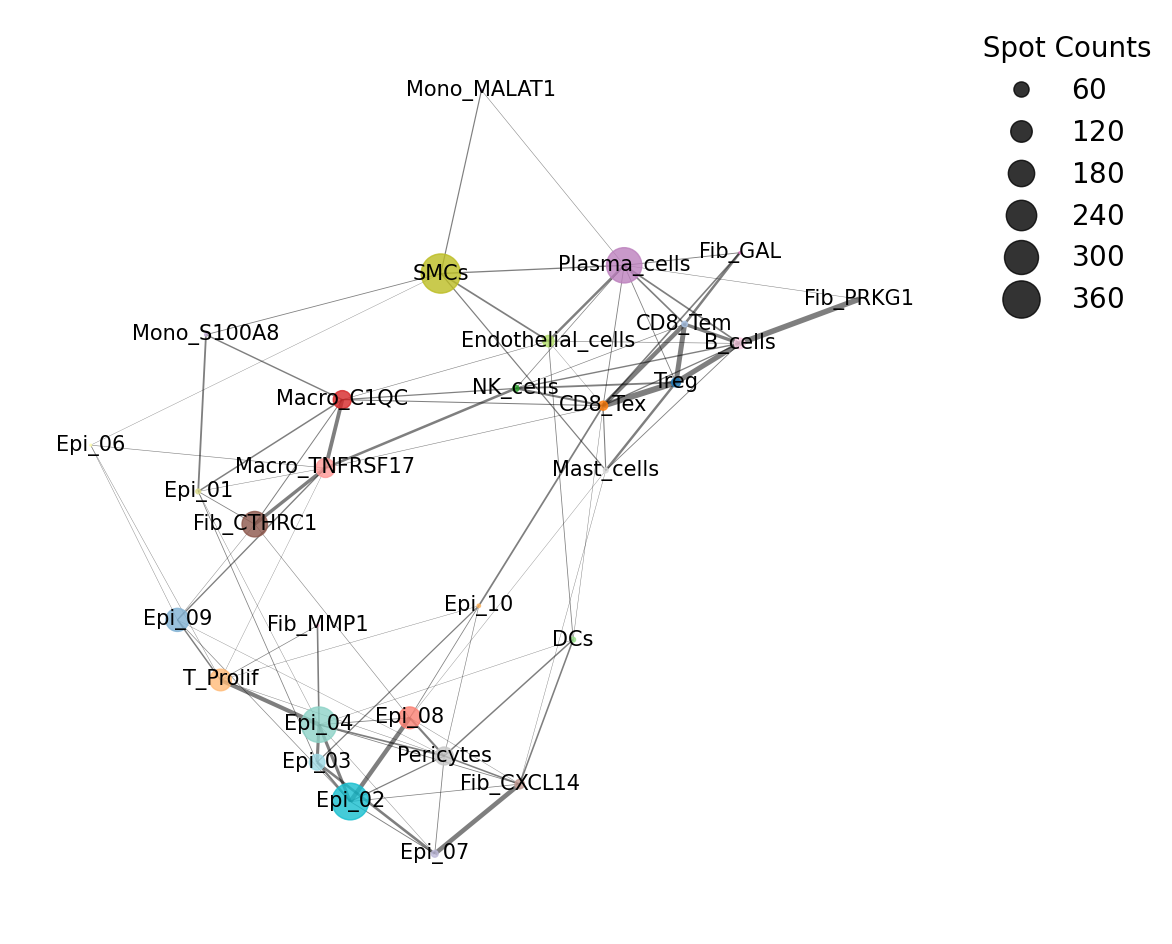

In [133]:
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.6)  # 适当增大 k 值防止label重合
sc_nodes = nx.draw_networkx_nodes(G, pos, node_color=node_colors, alpha=0.8, node_size=np.array(node_size)*2)
nx.draw_networkx_edges(G, pos, edge_color="black", alpha=0.5, width=0.25*(np.array(edge_widths)))
nx.draw_networkx_labels(G, pos, font_size=15, font_color="black", 
                        verticalalignment="center", horizontalalignment="center")
plt.axis("off")
plt.legend(*sc_nodes.legend_elements("sizes", num=6,func=lambda s: s / 2),
                   bbox_to_anchor=(1, 1), 
                   prop={'size': 20},
                   title = '  Spot Counts',
                   title_fontsize=20,  # 设置标题字体大小
                   frameon = False)
#func=lambda s: s / 2 作用是将图例中的节点大小除以 2，这样图例就会显示你希望的值。
plt.savefig(output_dir+'SC_Network4.svg', bbox_inches="tight", dpi = 600) #bbox_inches="tight" 表示自动调整图形的边界，使图形内容完全显示。
plt.show()

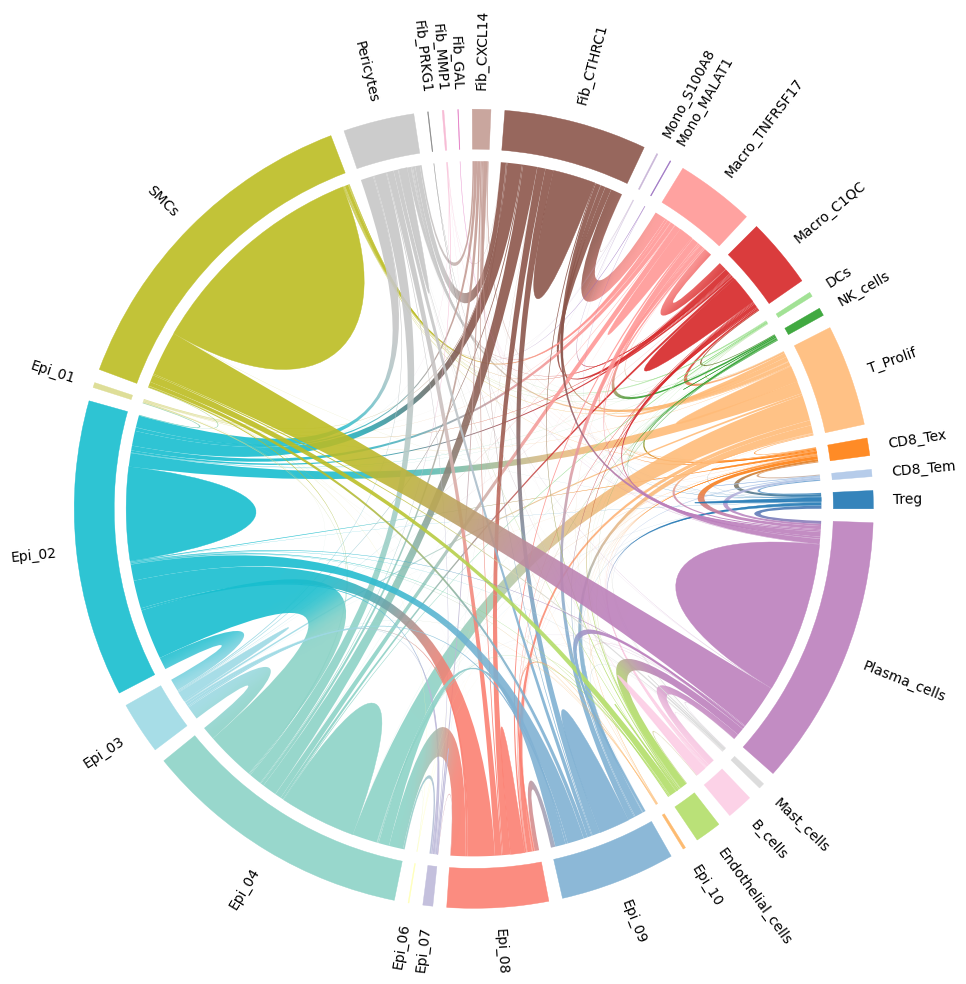

In [134]:
sq.gr.interaction_matrix(adata, cluster_key='predicted_cell_type', normalized = False)
#sq.pl.interaction_matrix(adata, cluster_key='predicted_cell_type',)# vmax = 5000, method="ward",)
df = pd.DataFrame(adata.uns['predicted_cell_type'+'_interactions'])
df_filt = df#[df.sum() > df.sum().quantile(0.6)]
df_filt = df_filt.T
df_filt = df_filt[df_filt.index.isin(df_filt.columns)]
colors =pd.DataFrame(adata.uns['predicted_cell_type'+'_colors'])
colors = colors[colors.index.isin(df_filt.columns)][0]
categories = pd.DataFrame(adata.obs['predicted_cell_type'].cat.categories)
categories = categories[categories.index.isin(df_filt.columns)][0]
df_filt.index = categories
df_filt.columns = categories
import random
randomlist = []
for i in range(0,19):
    n = random.uniform(0,1,)
    randomlist.append(n)
#df.index= adata.obs.level3.cat.categories
#df.columns= adata.obs.level3.cat.categories
with plt.rc_context({'figure.figsize': (10, 10), 'figure.dpi':100}):
    chord_diagram(df_filt, names = list(categories), 
                  rotate_names = True, fontcolor = 'black',
                  fontsize=10,colors = list(colors), alpha = 0.90,
                 sort = 'distance', use_gradient= True, show= False)
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42
    plt.rcParams['svg.fonttype'] = 'none'
    plt.savefig(output_dir+'SC_interaction_matrix.svg', bbox_inches="tight")
plt.show()

# 第四个样本

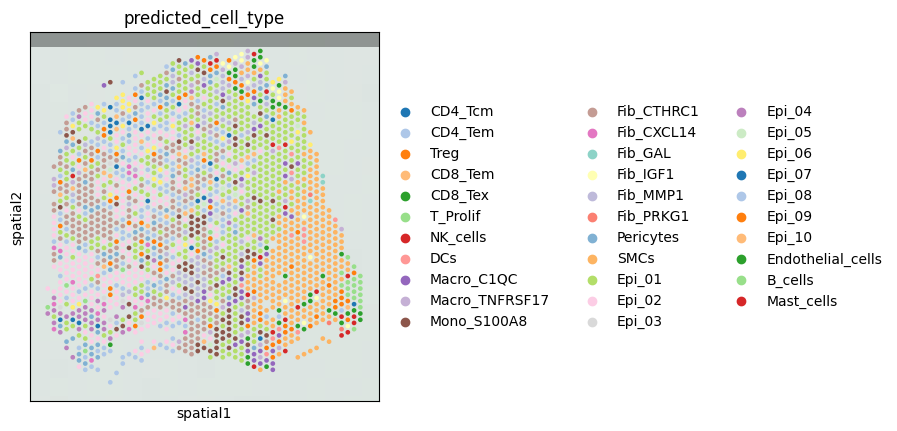

/home/yqcj/miniconda3/envs/squidpy/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:981: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


  0%|          | 0/1000 [00:00<?, ?/s]

/home/yqcj/miniconda3/envs/squidpy/lib/python3.9/site-packages/squidpy/gr/_nhood.py:202: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


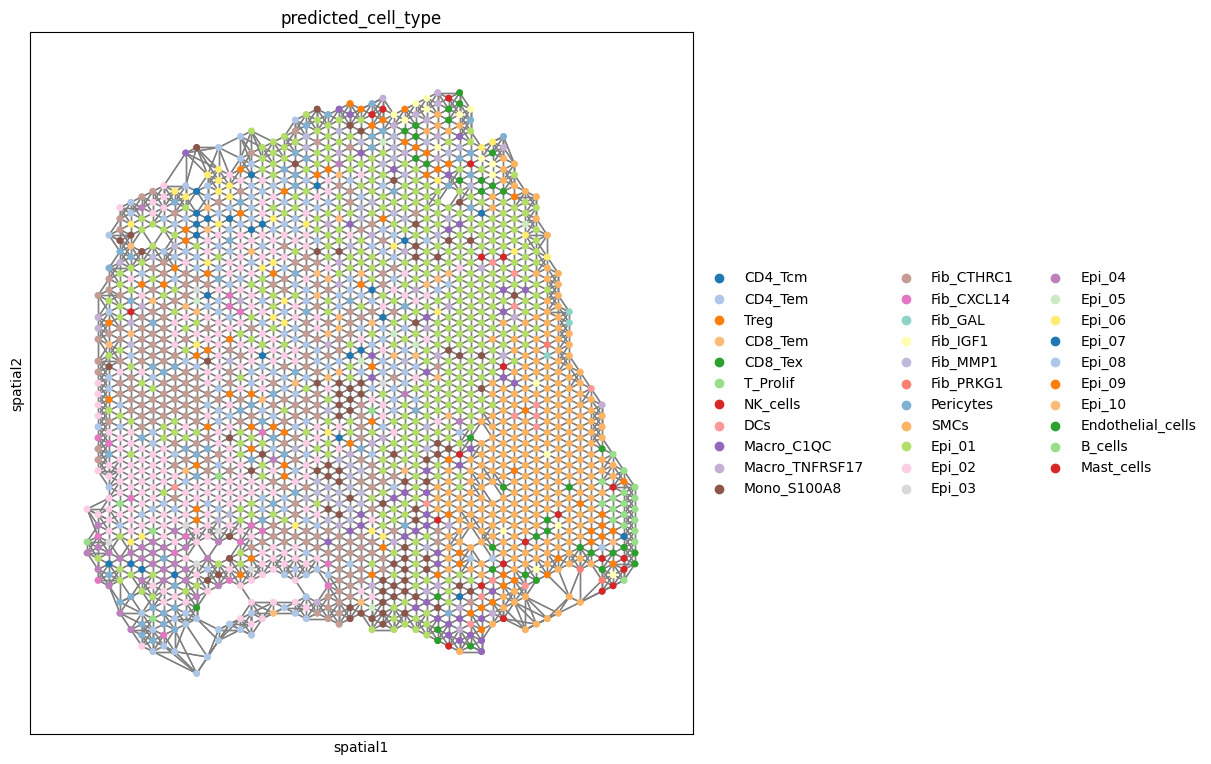

In [16]:
sample=sample_names[3]
adata=select_slide(adata_all, sample)
adata
adata.obs["array_row"]=adata.obs["array_row"]*2  #这个参数需要根据图长宽调整
adata.obsm["spatial"] = adata.obs[["array_row", "array_col"]].copy().to_numpy()
# 创建一个有30个颜色的调色板
palette = sns.color_palette("tab20", n_colors=13) + sns.color_palette("Set3", n_colors=20)
# 去除重复颜色
palette = list(dict.fromkeys(palette))  # 利用字典去重
sc.pl.spatial(adata, color="predicted_cell_type", spot_size=1.5,palette=palette,save="_"+sample+"_predict_Celltype_newcolor")
####计算邻域
sq.gr.spatial_neighbors(adata, library_key = 'sample',  coord_type="generic", delaunay=False,  n_neighs=6)
sq.pl.spatial_scatter(adata, 
                      color = 'predicted_cell_type',
                      #coords=adata.obsm['spatial'],
                     # crop_coord=region_subset_dict[sample],
                      size= 60,shape=None,
                      figsize=(12, 12), 
                      connectivity_key = 'spatial_connectivities', 
                     )#save = sample+'.svg')
output_dir = sample+"_Network/"
os.makedirs(output_dir, exist_ok=True)  # 创建目录（如果不存在）
plt.savefig(output_dir+'spatial_interaction.pdf')
sq.gr.nhood_enrichment(adata, cluster_key='predicted_cell_type')
adata.uns['predicted_cell_type'+'_nhood_enrichment']['zscore'] = np.nan_to_num(adata.uns['predicted_cell_type'+'_nhood_enrichment']['zscore'])
colors =pd.DataFrame(dict(zip(adata.obs['predicted_cell_type'].cat.categories,adata.uns['predicted_cell_type_colors'])).values())#pd.DataFrame(adata.uns['predicted_cell_type'+'_colors'])
for_eneritz = pd.DataFrame(adata.uns['predicted_cell_type'+"_nhood_enrichment"]["zscore"])
for_eneritz.index = adata.obs['predicted_cell_type'].cat.categories
for_eneritz.columns = adata.obs['predicted_cell_type'].cat.categories
#for_eneritz.to_csv(path+'SC_'+int_group+'_'+time+'_interaction_matrix.csv')
size = pd.DataFrame(adata.obs['predicted_cell_type'].value_counts())
# create network plot
G = nx.Graph()
nodes = adata.obs['predicted_cell_type'].cat.categories
categories = pd.DataFrame(adata.obs['predicted_cell_type'].cat.categories)
colors['cells'] = categories
nodes2 = []
for i,node in enumerate(((nodes))):
            for j in range(i+1, len(nodes)):
                zscore = adata.uns['predicted_cell_type'+"_nhood_enrichment"]["zscore"][i, j]
                pval = stats.norm.sf(abs(zscore))*2
                if zscore>1:
                    G.add_edge(nodes[i], nodes[j], weight=(zscore))
                    pos = nx.spring_layout(G, k=0.5, seed=42)
size = size[size.index.isin(pos.keys())]
size = size.sort_index()
colors = colors[colors.cells.isin(pos.keys())]
colors = dict(zip(colors['cells'], colors[0]))
edge_widths = [d['weight'] for u, v, d in G.edges(data=True)]
size = dict(zip(size.index, size['count']))
node_size = [size[node] for node in G.nodes()]
node_colors = [colors[node] for node in G.nodes()]

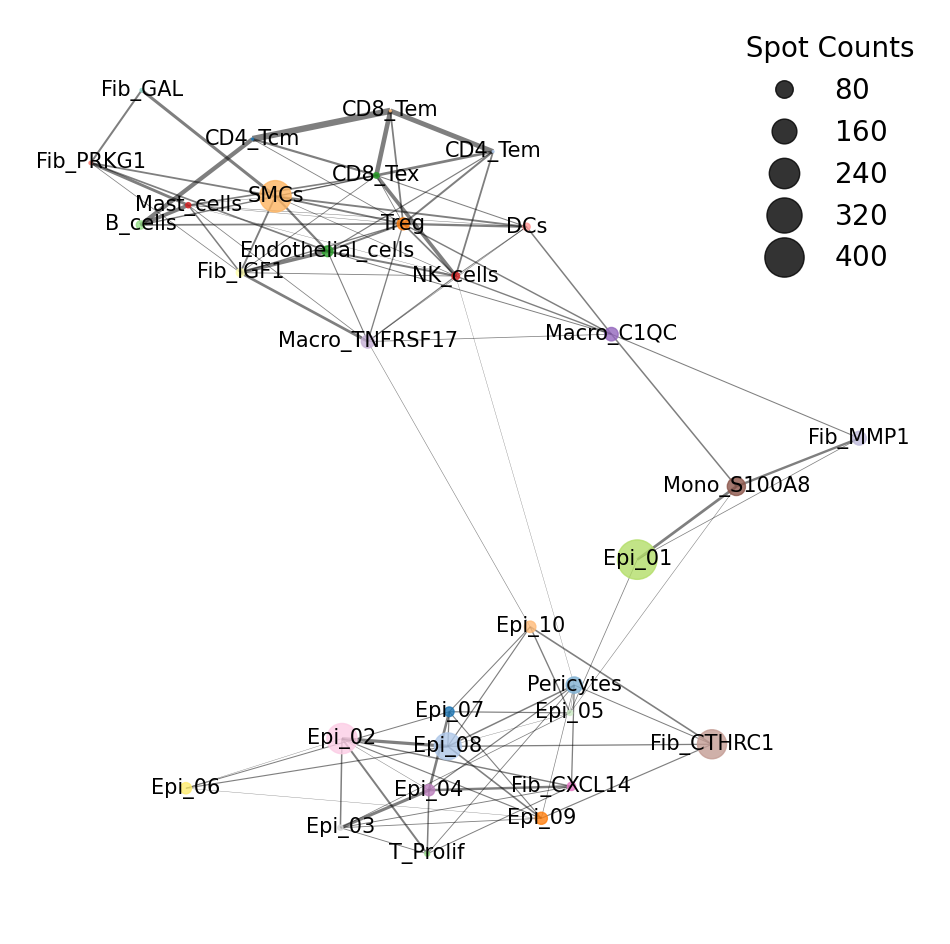

In [77]:
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.8)  # 适当增大 k 值防止label重合
sc_nodes  = nx.draw_networkx_nodes(G, pos, node_color=node_colors, alpha=0.8, node_size=np.array(node_size)*2)
nx.draw_networkx_edges(G, pos, edge_color="black", alpha=0.5, width=0.25*(np.array(edge_widths)))
nx.draw_networkx_labels(G, pos, font_size=15, font_color="black")
plt.axis("off")
plt.legend(*sc_nodes .legend_elements("sizes", num=6,func=lambda s: s / 2),
                   bbox_to_anchor=(1, 1), 
                   prop={'size': 20},
                   title = '  Spot Counts',
                   title_fontsize=20,  # 设置标题字体大小
                   frameon = False)
#func=lambda s: s / 2 作用是将图例中的节点大小除以 2，这样图例就会显示你希望的值。
plt.savefig(output_dir+'SC_Network3.svg', bbox_inches="tight", dpi = 600) #bbox_inches="tight" 表示自动调整图形的边界，使图形内容完全显示。
plt.show()

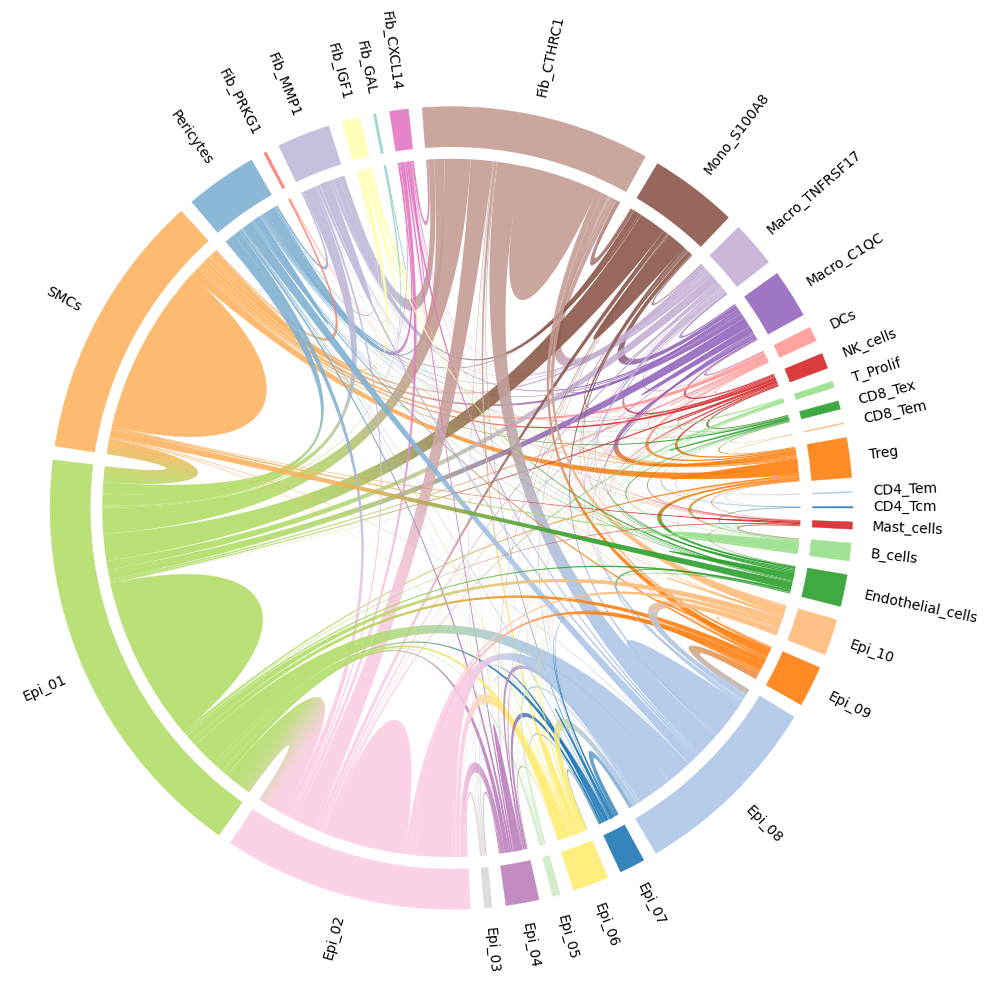

In [78]:
sq.gr.interaction_matrix(adata, cluster_key='predicted_cell_type', normalized = False)
#sq.pl.interaction_matrix(adata, cluster_key='predicted_cell_type',)# vmax = 5000, method="ward",)
df = pd.DataFrame(adata.uns['predicted_cell_type'+'_interactions'])
df_filt = df#[df.sum() > df.sum().quantile(0.6)]
df_filt = df_filt.T
df_filt = df_filt[df_filt.index.isin(df_filt.columns)]
colors =pd.DataFrame(adata.uns['predicted_cell_type'+'_colors'])
colors = colors[colors.index.isin(df_filt.columns)][0]
categories = pd.DataFrame(adata.obs['predicted_cell_type'].cat.categories)
categories = categories[categories.index.isin(df_filt.columns)][0]
df_filt.index = categories
df_filt.columns = categories
import random
randomlist = []
for i in range(0,19):
    n = random.uniform(0,1,)
    randomlist.append(n)
#df.index= adata.obs.level3.cat.categories
#df.columns= adata.obs.level3.cat.categories
with plt.rc_context({'figure.figsize': (10, 10), 'figure.dpi':100}):
    chord_diagram(df_filt, names = list(categories), 
                  rotate_names = True, fontcolor = 'black',
                  fontsize=10,colors = list(colors), alpha = 0.90,
                 sort = 'distance', use_gradient= True, show= False)
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42
    plt.rcParams['svg.fonttype'] = 'none'
    plt.savefig(output_dir+'SC_interaction_matrix.svg', bbox_inches="tight")
plt.show()